# Museum project by Roussau Claude & Jeandel Florian

### Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
from pandas import DataFrame
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA 
import os
from sklearn.cluster import DBSCAN
from itertools import product
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import missingno as msn

#### Import des données

In [2]:
path='C:/Users/Flo/Downloads/an13.csv'
path2='C:/Users/Flo/Downloads/in13.csv'
path3='C:/Users/Flo/Downloads/data1.csv'

In [3]:
an13=pd.read_csv(path,encoding='latin1')
an13 = an13.rename({'codcliente': 'consumer_ID', 'data_inizio': 'card_starting_date', 'importo': 'price_paid', 'sconto': 'discount_type', 'riduzione': 'type_of_price_reduction', 'tipo_pag': 'mode_of_payment', 'agenzia': 'organization_name', 'agenzia_tipo': 'place_of_card_buying', 'sesso': 'gender', 'data_nascita' : 'birth_year', 'professione': 'employment_statut', 'comune':'city', 'cap':'local_area_code','nuovo_abb': 'new_subscriber'}, axis=1)
in13 = pd.read_csv(path2, encoding='latin1')
in13 = in13.rename({'datai': 'date_of_visit', 'orai': 'time_of_visit', 'importo': 'ticket_price','museo':'museum','prov_museo':'museum_province', 'com_museo':'museum_city', 'CodCliente': 'consumer_ID'}, axis=1)

data1= pd.read_csv(path3, encoding='latin1')
data1 = data1.rename({'codcliente': 'consumer_ID', 'si2014': 'churn', 'ultimo_ing.x': 'last_visit_date', 'abb13': 'starting_date_2013', 'abb14': 'starting_date_2014'}, axis=1)
# Si2014: label. 0 for churn (s'en va) 1 si il reste

## Question 1
Describe the most interesting variables by plotting distributions, correlations, co-occurrence.
(HINT: don’t do it for all the variables, choose meaningful ones). (MAX 10 points).

## Statistiques descriptives

### Merge & data preparation

In [4]:
df = pd.merge(data1, an13, on='consumer_ID', how='left')
df = pd.merge(df, in13, on='consumer_ID', how='left')
df['nbr_visit']=df.groupby('consumer_ID')['consumer_ID'].transform('count') # comptage par id des visites aux musées
# on enlève ceux qui ont trop visité pck c'est des outlier
df = df.drop('employment_statut', axis=1) # tout est vode donc on drop
df = df[df['starting_date_2013'].notna()] # on fait une étude longitudinale de 2013 à 2014, pas besoin des nouveaux de 2014
df['discount_yn'] = np.where(df['discount_type']=='NESSUNO SCONTO', 0, 1)# on fait une variable qui dit si y'a discount=1 sinon 0
df['gender'] = np.where(df['gender']=='F', 0, 1)
df = df[df.gender > -1]
df = df.drop(["Unnamed: 0_x"], axis=1) # drop des variables inutiles
df= df.drop(["Unnamed: 0_y"], axis=1) # sans doute des anciens id
df= df.drop(["Unnamed: 0"], axis=1)


checking birth year

In [5]:
df["birth_year"]=df["birth_year"].str.replace("-","")

In [6]:
df["birth_year"]=df["birth_year"].astype(float)

In [7]:
df["birth_year"].unique()

array([1947., 1974., 1970., 1969., 1986., 1991., 1949., 1976., 1936.,
       1992., 1941., 1931., 1971., 1943., 1967., 1945., 1937., 1965.,
       1946., 1987., 1959., 1962., 1948., 1979., 1998., 1994., 1983.,
       1980., 1978., 1927., 1997., 1960., 1956., 1984., 1972., 1950.,
       1953., 1990., 1993., 1989., 1985., 1954., 1963., 1940., 1975.,
       1932., 1964., 1955., 1938., 1957., 1952., 1944., 1939., 1933.,
       1995., 1981., 1988., 1961., 1973., 1996., 1951., 1942., 2003.,
       1982., 1928., 1958., 1968., 1966., 2002., 1977., 1934., 1935.,
       1999., 1930., 2006., 2004., 2000., 1929., 1926., 1922., 2001.,
       1925., 1924., 1901., 2005., 1920., 1917., 1900., 1923., 1916.,
       1921., 2007., 2011., 2013., 2008.,  902., 2012., 1914.,  101.,
       2022., 1919., 2076., 2028., 1903., 1915., 2026., 1918.])

Creating a variable age

In [8]:
df["age"]= 2014 - df["birth_year"]

In [9]:
df2=df.groupby('consumer_ID') # on réduit les id (plus de repetitions)
df2 =df2.mean()
#df2

## Stats after merge

a lot of missing values in starting date 2014

In [10]:
print(df.isnull().sum())

consumer_ID                     0
churn                           0
last_visit_date              8090
starting_date_2013              0
starting_date_2014         106002
card_starting_date              0
price_paid                      0
discount_type                   0
type_of_price_reduction         0
mode_of_payment                 0
organization_name               0
place_of_card_buying            0
gender                          0
birth_year                      0
city                            0
local_area_code                 0
new_subscriber                  0
date_of_visit                8463
time_of_visit                8463
ticket_price                 8463
museum                       8463
museum_province              8463
museum_city                  8463
nbr_visit                       0
discount_yn                     0
age                             0
dtype: int64


<AxesSubplot:>

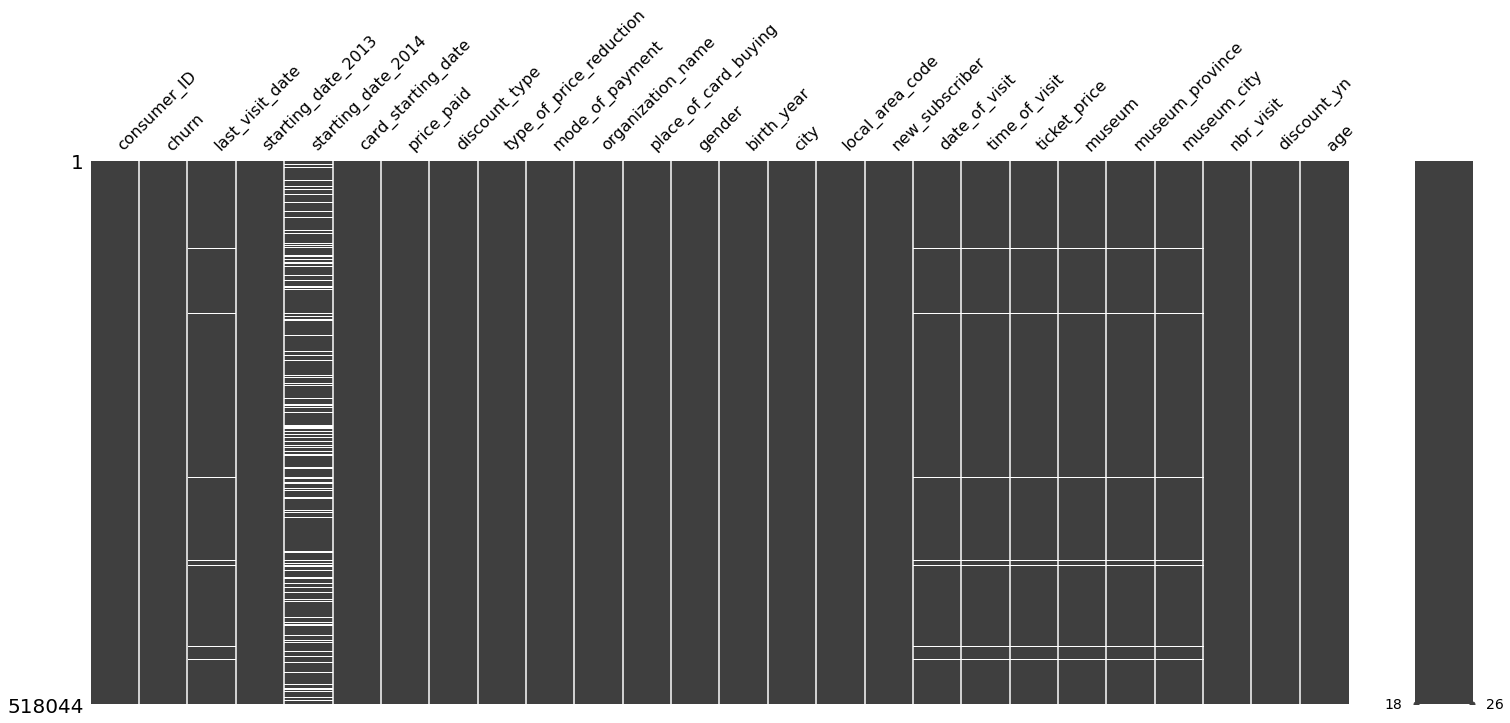

In [11]:
msn.matrix(df)

In [12]:
df2._get_numeric_data().describe().transpose()

,count,mean,std,min,25%,50%,75%,max
churn,80140.0,0.693873,0.460886,0.0,0.0,1.000,1.000000,1.0
price_paid,80140.0,35.142675,10.009043,0.0,28.0,30.000,44.000000,49.0
gender,80140.0,0.451909,0.497685,0.0,0.0,0.000,1.000000,1.0
birth_year,80140.0,1961.102758,18.891650,101.0,1947.0,1958.000,1974.000000,2076.0
ticket_price,71677.0,4.418652,0.796299,0.5,4.0,4.475,4.946429,10.0
nbr_visit,80140.0,6.464238,6.310765,1.0,2.0,5.000,9.000000,264.0
discount_yn,80140.0,0.662316,0.472923,0.0,0.0,1.000,1.000000,1.0
age,80140.0,52.897242,18.891650,-62.0,40.0,56.000,67.000000,1913.0


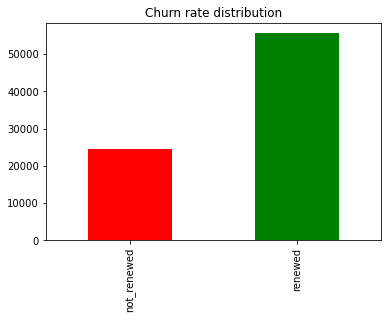

We have 69.39% de churn.


In [13]:
pani =df2['churn'].value_counts()
pani = [24533,55603]
s = pd.Series(
    pani,
    index = ["not_renewed", "renewed"]
)
plt.title("Churn rate distribution")
ax = plt.gca()
ax.tick_params(axis='x')
ax.tick_params(axis='y')
my_colors = list('rg') 

s.plot( 
    kind='bar', 
    color=my_colors,
)
plt.show()
pourcentage_churn = 55603/(55603+ 24533)*100
print('We have ' + str(round(pourcentage_churn,2)) + '% de churn.')

More renewed than not renewed

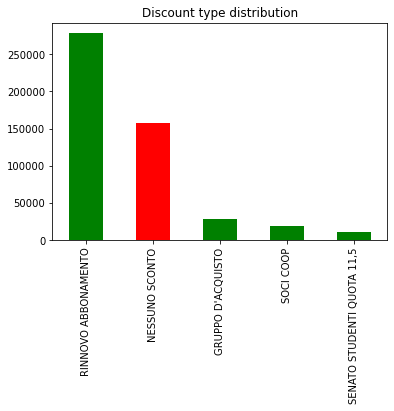

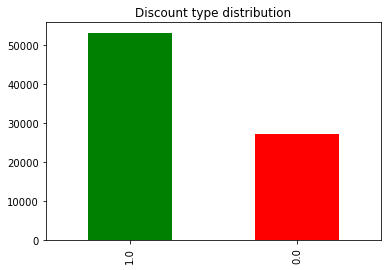

66.23% got discount.


In [14]:
pani1=df['discount_type'].value_counts()
pani1 = pani1.drop(pani1[pani1 < 5000].index)

s = pd.Series(
    pani1,
)
plt.title("Discount type distribution")
ax = plt.gca()
ax.tick_params(axis='x')
ax.tick_params(axis='y')
my_colors = list('grggg')  

s.plot( 
    kind='bar', 
    color=my_colors,
)
plt.show()

pani1=df2['discount_yn'].value_counts()
#pani1 = pani1.drop(pani1[pani1 < 5000].index)

s = pd.Series(
    pani1,
)
plt.title("Discount type distribution")
ax = plt.gca()
ax.tick_params(axis='x')
ax.tick_params(axis='y')
my_colors = list('gr')  

s.plot( 
    kind='bar', 
    color=my_colors,
)
plt.show()

pourcentage_discount = 53074/(27062+ 53074)*100
print( str(round(pourcentage_discount,2)) + '% got discount.')

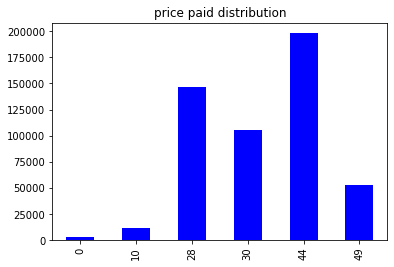

In [15]:
import matplotlib.cm as cm

pani2 = df['price_paid'].value_counts().sort_index()
s = pd.Series(pani2)

# Définir la palette de couleur
#cmap = cm.get_cmap('viridis')
plt.title("price paid distribution")
ax = plt.gca()
ax.tick_params(axis='x')
ax.tick_params(axis='y')

# Normaliser les données pour une utilisation dans la palette de couleur
norm = plt.Normalize(vmin=min(s), vmax=max(s))

s.plot(kind='bar', color="blue")
plt.show()

most of the prices paid are 44 euros 

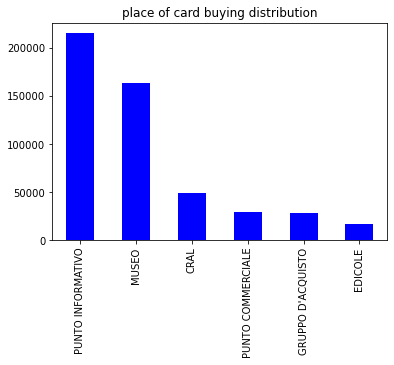

In [16]:
pani2=df['place_of_card_buying'].value_counts()
pani2 = pani2.drop(pani2[pani2 < 15000].index)
s = pd.Series(
    pani2,
)
plt.title("place of card buying distribution")
ax = plt.gca()
ax.tick_params(axis='x')
ax.tick_params(axis='y')
my_colors = "blue"  
s.plot( 
    kind='bar', 
    color=my_colors,
)
plt.show()

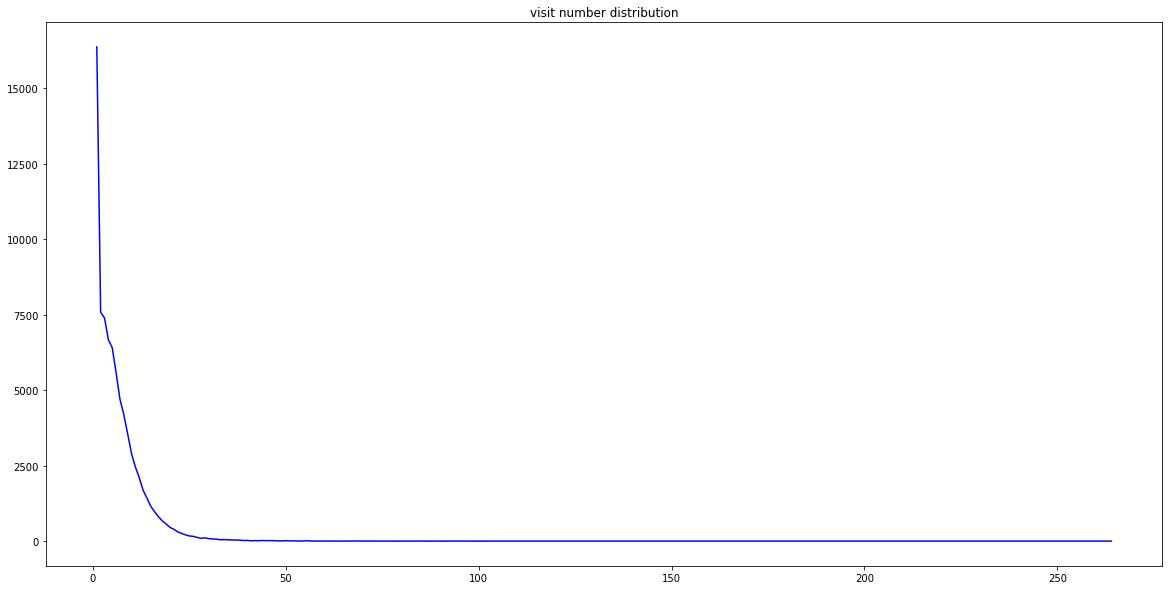

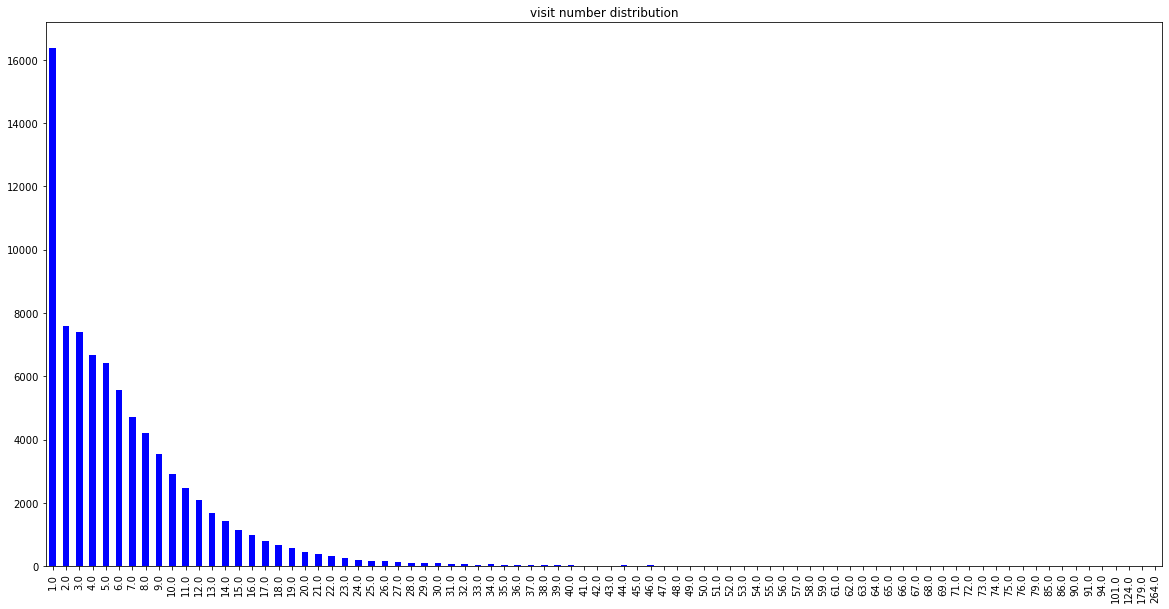

In [17]:
plt.figure(figsize=(20,10))
pani2=df2['nbr_visit'].value_counts().sort_index()
s = pd.Series(
    pani2,
)
plt.title("visit number distribution")
ax = plt.gca()
ax.tick_params(axis='x')
ax.tick_params(axis='y')
my_colors = "blue"
s.plot( 
    kind='line', 
    color=my_colors,
)
plt.show()

plt.figure(figsize=(20,10))
pani2=df2['nbr_visit'].value_counts().sort_index()
s = pd.Series(
    pani2,
)
plt.title("visit number distribution")
ax = plt.gca()
ax.tick_params(axis='x')
ax.tick_params(axis='y')
my_colors = "blue"
s.plot( 
    kind='bar', 
    color=my_colors,
)
plt.show()

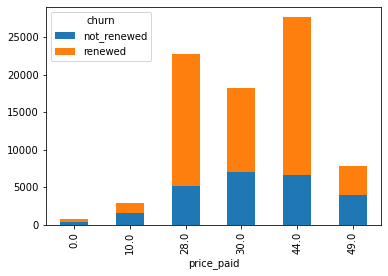

It's seems that highest the price paid is, highest the churn rate is


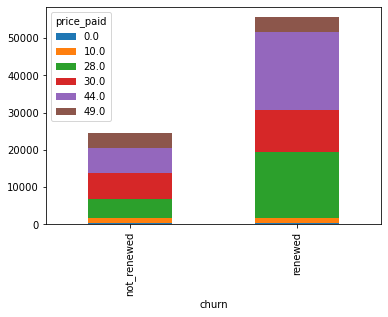

It's seems that highest the price paid is, highest the churn rate is


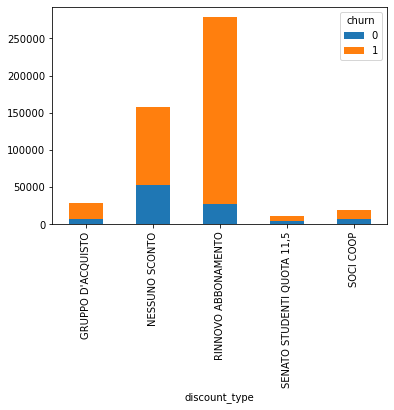

It's seems that the type of discount impact the churn rate 


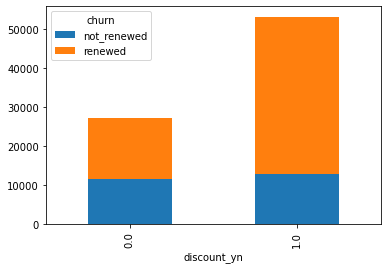

It's seems that the type of discount the churn rate 


In [18]:
df2['churn']=df2['churn'].replace(0, "not_renewed")
df2['churn']=df2['churn'].replace(1, "renewed")
df2['churn']

# 1
df2.groupby(['price_paid','churn']).size().unstack().plot(kind='bar',stacked=True)
plt.show()
print("It's seems that highest the price paid is, highest the churn rate is")

#2
df2.groupby(['churn','price_paid']).size().unstack().plot(kind='bar',stacked=True)
plt.show()
print("It's seems that highest the price paid is, highest the churn rate is")

#3
panini= df.loc[df['discount_type'].isin(['RINNOVO ABBONAMENTO' , 'NESSUNO SCONTO', "GRUPPO D'ACQUISTO", "SOCI COOP", "SENATO STUDENTI QUOTA 11,5"])]
panini.groupby(['discount_type','churn']).size().unstack().plot(kind='bar',stacked=True)
plt.show()
print("It's seems that the type of discount impact the churn rate ")
#4
df2.groupby(['discount_yn','churn']).size().unstack().plot(kind='bar',stacked=True)
plt.show()
print("It's seems that the type of discount the churn rate ")

## Heatmap

<AxesSubplot:>

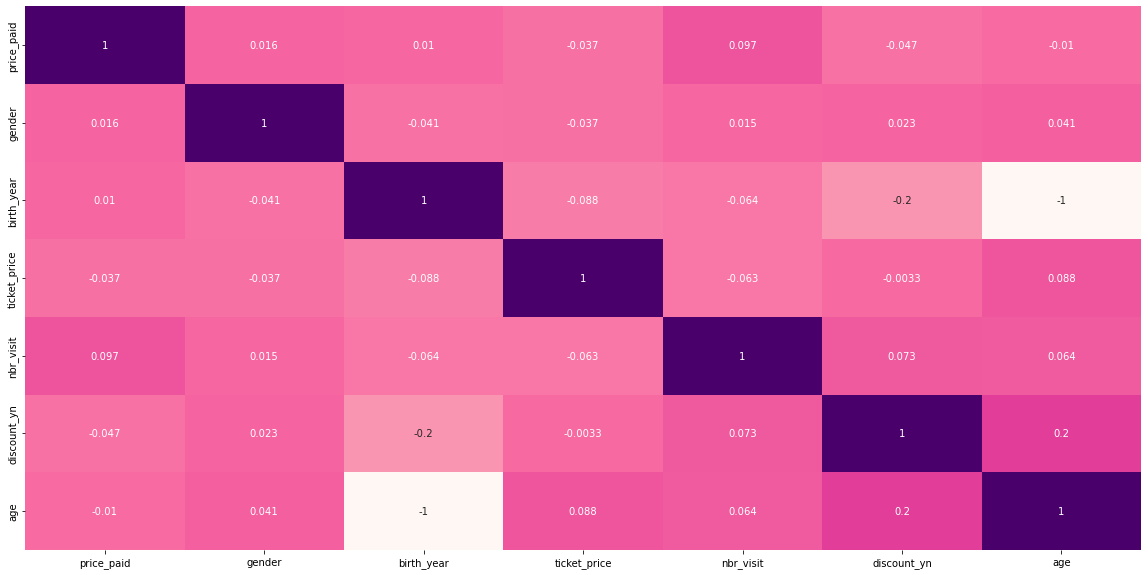

In [19]:
plt.figure(figsize=(20,10))
sns.heatmap(df2.corr(),annot=True,cmap="RdPu",cbar=False)

Not so much correlation, just birth year and age, pretty logical

# Question 2 & 3
2. Do you spot some problem with the variables? Are there any specific problems you should
take care about? (HINT: there might be some mistakes in the data entry. You can find those
by graphically looking at outliers) (MAX 10 points).

3. Analyse graphically the pattern of missing values. Is there any variable you should drop from
the analysis? (MAX 10 points).

<AxesSubplot:xlabel='price_paid'>

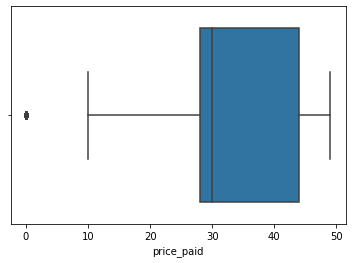

In [20]:
sns.boxplot(x=df2["price_paid"])

It's seems there is not outliers for price paid 

<AxesSubplot:xlabel='age'>

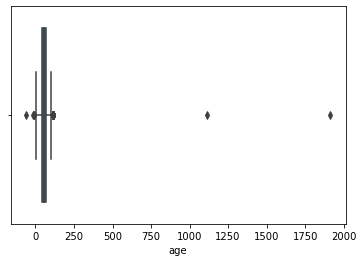

In [21]:
sns.boxplot(x=df2["age"])

It's seems there is outliers for age

(array([8.0138e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ -62. ,  135.5,  333. ,  530.5,  728. ,  925.5, 1123. , 1320.5,
        1518. , 1715.5, 1913. ]),
 <BarContainer object of 10 artists>)

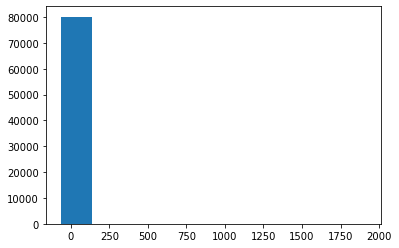

In [22]:
plt.hist(df2["age"])

It's seems there is outliers for age

So we select age between 0 and 100

(array([  203.,  2554.,  8428.,  9121., 12483., 15109., 20061., 10355.,
         1719.,    75.]),
 array([  1. ,  10.9,  20.8,  30.7,  40.6,  50.5,  60.4,  70.3,  80.2,
         90.1, 100. ]),
 <BarContainer object of 10 artists>)

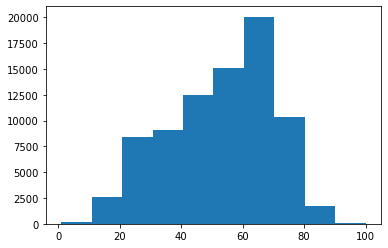

In [23]:
df2=df2[(df2['age'] >= 0) & (df2['age'] <= 100)]
plt.hist(df2["age"])

More logical

<AxesSubplot:xlabel='ticket_price'>

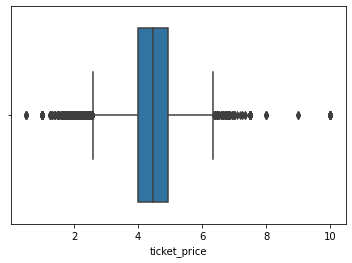

In [24]:
sns.boxplot(x=df2["ticket_price"])

It's seems there is not outliers for ticket price

<AxesSubplot:xlabel='nbr_visit'>

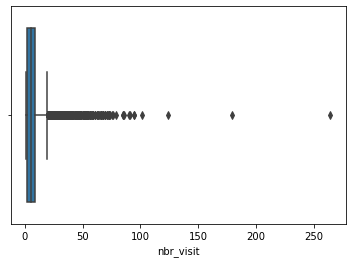

In [25]:
sns.boxplot(x=df2["nbr_visit"]) #3eme quartile à 20, le reste est très haut

It's seems there is not outliers for the number of visit, just some big fans.

Clean start date, we have a start date that starts on the wrong date

In [26]:
frederic = df['starting_date_2013'].str.replace('-','')
frederic = frederic.unique()
frederic=np.delete(frederic,0)
np.sort(frederic)[0:3]
#On a des données de décembre 2012 pour le starting date 2013

array(['20121025', '20121201', '20121202'], dtype=object)

In [27]:
delavier = df['starting_date_2014'].str.replace('-','')
delavier = delavier.unique()
delavier=np.delete(delavier,0)
np.sort(delavier)[0:3]
#On a des données 2013 pour le starting date 2014

array(['20131201', '20131202', '20131203'], dtype=object)

In [28]:
df=df.drop(df[df.starting_date_2013.str.contains(r'2012')].index)
df=df.drop(df[df.starting_date_2014.str.contains(r'2013', na=False)].index)
# on retire les mauvaises valeurs dans nos données

# Question 4
Can you cluster the observations? Is there a cluster with most churners? (MAX 20 points)

In [29]:
df2['churn']=np.where(df2['churn']=="renewed",1,0)

In [30]:
from sklearn.model_selection import train_test_split
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

X = df2.drop('churn', axis=1)
y = df2['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
df2 = df2[df2['ticket_price'].notna()] # y'a des NaN au k-means donc je le drop

drop na

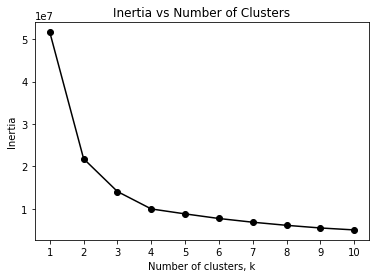

In [32]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Create an empty list to store the inertias
inertias = []

# Iterate over a range of values for k
for k in range(1,11):
    # Create a KMeans model with the current value of k
    model = KMeans(n_clusters = k, init = 'k-means++', n_init = 10, max_iter = 300, random_state = 0)
    # Fit the model to the data
    model.fit(df2)
    # Append the inertia to the list
    inertias.append(model.inertia_)

# Plot the inertia values against the number of clusters
plt.plot(range(1,11), inertias, '-o', color='black')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(range(1,11))
plt.title('Inertia vs Number of Clusters')
plt.show()

# use KneeLocator to find the elbow point
#kl = KneeLocator(range(1, 11), inertias, curve="convex", direction="decreasing")
#kl.elbow
#plt.axvline(kl.elbow, color = "red", linestyle = "--")
#plt.show()

# 4 clusters

4 seems to be our optimal k

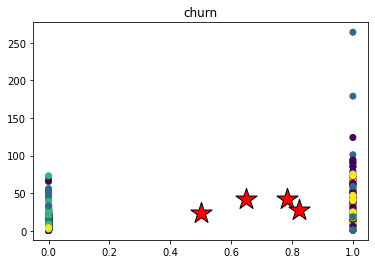

[[ 0.78409385 41.81618218]
 [ 0.64930671 41.89528564]
 [ 0.50085781 23.79150267]
 [ 0.82282429 28.04375792]]


In [33]:
model = KMeans(n_clusters=4, init = 'k-means++', n_init = 1) # cluster de 3 pck en haut
model.fit(df2)
# coordinates of cluster center
centroids = model.cluster_centers_ 
# cluster label for each data point
labels = model.labels_ 
plt.scatter(df2["churn"],df2['nbr_visit'],c=labels)
#plt.scatter(PCA_components[0], PCA_components[1], c=labels)
plt.scatter( centroids[:, 0], centroids[:, 1], s=500, marker='*', c='red', edgecolor='black')
plt.title('churn')
plt.show()
print(centroids[:,0:2])
# c'est pour rep à la question de "est ce que y'a un cluster avec plus de churn donc la vizu est moche"
# dans tout les cas nos variables sont numériques mais un peu catégorielle donc c'est tout le temps moche

4 clusters

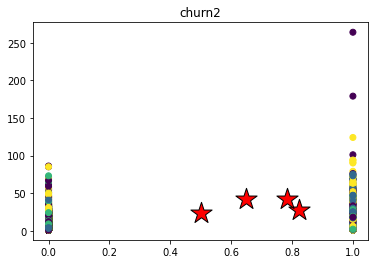

[[ 0.64928437 41.89803617]
 [ 0.82282429 28.04375792]
 [ 0.50095834 23.79380611]
 [ 0.78409385 41.81618218]]


In [34]:
model = KMeans(n_clusters=4, init = 'k-means++', n_init = 1) # cluster de 3 pck en haut
model.fit(df2)
# coordinates of cluster center
centroids = model.cluster_centers_ 
# cluster label for each data point
labels = model.labels_ 
plt.scatter(df2["discount_yn"],df2['nbr_visit'],c=labels)
#plt.scatter(PCA_components[0], PCA_components[1], c=labels)
plt.scatter( centroids[:, 0], centroids[:, 1], s=500, marker='*', c='red', edgecolor='black')
plt.title('churn2')
plt.show()
print(centroids[:,0:2])

4 clusters

In [35]:
df2['clusters'] = labels
df2.groupby(["clusters"]).agg({
    'churn': 'mean', 
    'price_paid': 'median', 
    'nbr_visit': 'median', 
    'gender': 'mean',
    'discount_yn': 'mean'
})

,churn,price_paid,nbr_visit,gender,discount_yn
clusters,,,,,
0,0.649218,44.0,5.0,0.460464,0.636908
1,0.822824,28.0,6.0,0.478413,0.778969
2,0.500909,28.0,4.0,0.397819,0.463752
3,0.784103,44.0,6.0,0.442619,0.695950


Cluster 2 got the highest churn mean, median price paid 28  euros, median visit is 6, mean discount 77%

# Question 5
Is there a causal impact of gender on the probability of churning? Identify a suitable model to
create a counterfactual group with observational data. Present graphically the result in a
meaningful way (MAX 15 points)

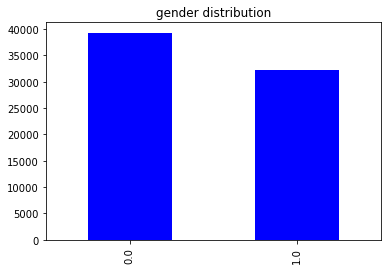

In [36]:
pani2=df2['gender'].value_counts()
s = pd.Series(
    pani2,
)
plt.title("gender distribution")
ax = plt.gca()
ax.tick_params(axis='x')
ax.tick_params(axis='y')
my_colors = "blue"  
s.plot( 
    kind='bar', 
    color=my_colors,
)
plt.show()
# 0=F 1=M

More female than male in our dataset

In [37]:
import statsmodels.api as sm
X = df2.drop('churn', axis=1)
y = df2.churn
model = sm.Logit(y, X)
result = model.fit(method='newton')
result.summary()
# pr>z est minuscule donc gender significatif
# gender a bien un impact sur le churn rate
# être un homme baisse les chances de rester
# churn=1 c'est reprendre un abo et churn=0 c'est pas reprendre

Optimization terminated successfully.
         Current function value: 0.529794
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                71647
Model:                          Logit   Df Residuals:                    71639
Method:                           MLE   Df Model:                            7
Date:                Sat, 14 Jan 2023   Pseudo R-squ.:                  0.1035
Time:                        21:39:49   Log-Likelihood:                -37958.
converged:                       True   LL-Null:                       -42341.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
price_paid      -0.0026      0.001     -2.938      0.003      -0.004      -0.001
gender          -0.1403      0.018     -7.839      0.000      -0.175      -0.105
birth_year      -0.0007   3.13e-05    -23.173      0.000      -0.001      -0.001
ticket_price     0.0157      0.011      1.478      0.139      -0.005       0.036
nbr_visit        0.1039      0.002     49.767      0.000       0.100       0.108
discount_yn      0.6545      0.018     35.502      0.000       0.618       0.691
age              0.0260      0.001     49.319      0.000       0.025       0.027
clusters         0.0487      0.007      6.503      0.000       0.034       0.063
================================================================================
"""

all our variable except the ticket price are significants. Male got less probabilty to churn than woman.

In [38]:
churn_by_gender = df2.groupby(['gender', 'churn']).size().unstack()
observed_difference = churn_by_gender[1][1] / sum(churn_by_gender[1]) -  churn_by_gender[1][0] / sum(churn_by_gender[1])

In [39]:
import numpy as np
np.random.seed(123)
n_iterations = 1000
differences = []
for i in range(n_iterations):
    shuffled_gender = np.random.permutation(df2['gender'])
    shuffled_data = df2.assign(gender=shuffled_gender)
    shuffled_churn_by_gender = shuffled_data.groupby(['gender', 'churn']).size().unstack()
    shuffled_difference = (shuffled_churn_by_gender[1][1] / sum(shuffled_churn_by_gender[1]) 
                          -  shuffled_churn_by_gender[1][0] / sum(shuffled_churn_by_gender[1]))
    differences.append(shuffled_difference)

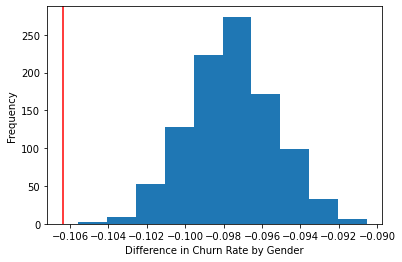

In [40]:
import matplotlib.pyplot as plt
plt.hist(differences)
plt.axvline(x=observed_difference, color='red')
plt.xlabel('Difference in Churn Rate by Gender')
plt.ylabel('Frequency')
plt.show()
# une espèce de p_value, on garde H0

The histogram displays the distribution of gender differences in churn rates in randomly generated counterfactual groups using permutation. The observed difference in the actual data (plotted in red) is compared to this distribution. There is a difference between gender to churn.

# Question 6
Which models could you use to predict churners? Run at least three prediction models and
show the ROC curves for them. Compute the predicted probability on the test-set and show
its distributions for true positive and true negative (HINT: you might want do some features
engineering and create variables such as: total number of visits, day of the last visit)(MAX 15
points).

In [41]:
from imblearn.under_sampling import RandomUnderSampler

# Create an instance of the undersampler
undersampler = RandomUnderSampler()

# Fit and transform the undersampler on the data

df2= df2.dropna()
X = df2.drop('churn', axis=1)
y = df2.churn
X_resampled, y_resampled = undersampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [42]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        plt.figure(figsize=(20,10))
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        #print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")
        print(f"Confusion Matrix: \n")
        ax= plt.subplot()
        sns.heatmap(confusion_matrix(y_test, pred),annot=True,cmap="RdPu",fmt='g',annot_kws={'size': 40},)
        ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')

## logistic regression

Train Result:
Accuracy Score: 73.16%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.555710      0.751308  0.731636      0.653509      0.696625
recall         0.199914      0.937976  0.731636      0.568945      0.731636
f1-score       0.294047      0.834328  0.731636      0.564188      0.683282
support    14021.000000  36131.000000  0.731636  50152.000000  50152.000000
_______________________________________________
Confusion Matrix: 
 [[ 2803 11218]
 [ 2241 33890]]

Test Result:
Accuracy Score: 73.63%
_______________________________________________
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision     0.551515      0.756744  0.736264      0.654130      0.700508
recall        0.200849      0.938353  0.736264      0.569601      0.736264
f1-score      0.294462      0.837820  0.736264      0.566141      0.688931
suppo

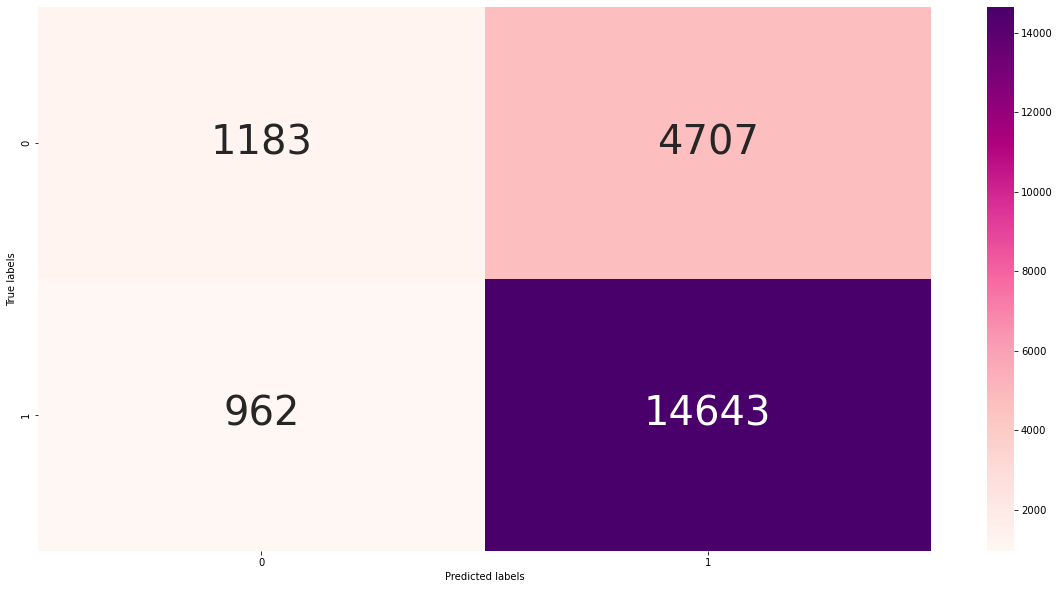

In [43]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)

print_score(lr_clf, X_train, y_train, X_test, y_test, train=True)
print_score(lr_clf, X_train, y_train, X_test, y_test, train=False)

In [44]:
test_score = accuracy_score(y_test, lr_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, lr_clf.predict(X_train)) * 100

results_df = pd.DataFrame(data=[["Logistic Regression", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Logistic Regression,73.163583,73.626425


## k-nearest 

Train Result:
Accuracy Score: 79.85%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.694486      0.824606  0.798493      0.759546      0.788229
recall         0.498538      0.914893  0.798493      0.706715      0.798493
f1-score       0.580420      0.867407  0.798493      0.723913      0.787174
support    14021.000000  36131.000000  0.798493  50152.000000  50152.000000
_______________________________________________
Confusion Matrix: 
 [[ 6990  7031]
 [ 3075 33056]]

Test Result:
Accuracy Score: 71.51%
_______________________________________________
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision     0.472548      0.775083  0.715097      0.623815      0.692183
recall        0.341935      0.855944  0.715097      0.598940      0.715097
f1-score      0.396769      0.813509  0.715097      0.605139      0.699315
suppo

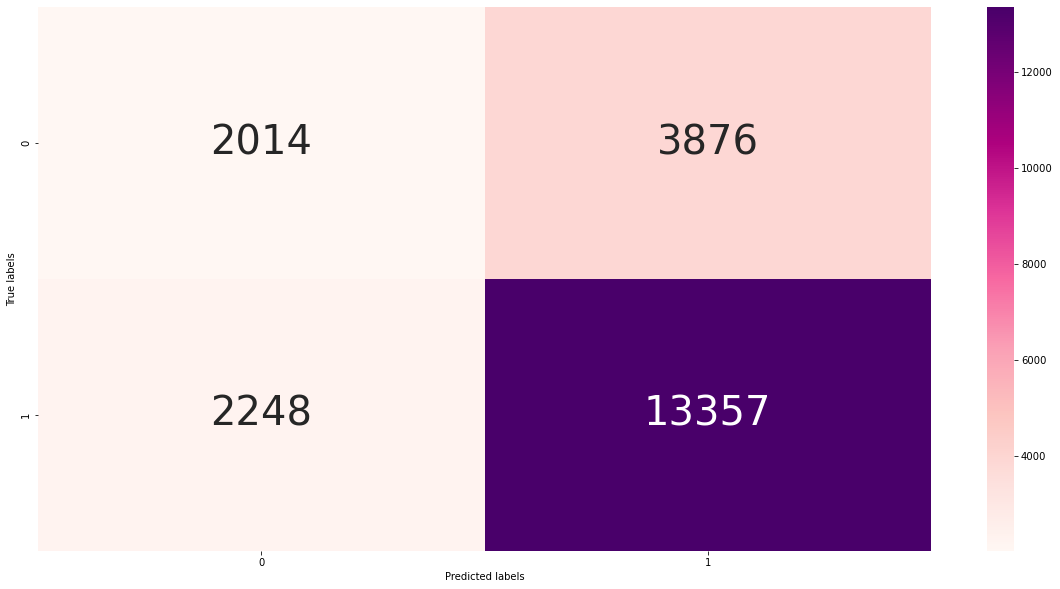

In [45]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

print_score(knn_clf, X_train, y_train, X_test, y_test, train=True)
print_score(knn_clf, X_train, y_train, X_test, y_test, train=False)

In [46]:
test_score = accuracy_score(y_test, knn_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, knn_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["K-nearest neighbors", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Logistic Regression,73.163583,73.626425
1,K-nearest neighbors,79.849258,71.509653


## Decision tree

Train Result:
Accuracy Score: 94.61%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.878470      0.974802  0.946084      0.926636      0.947870
recall         0.936738      0.949711  0.946084      0.943224      0.946084
f1-score       0.906669      0.962093  0.946084      0.934381      0.946598
support    14021.000000  36131.000000  0.946084  50152.000000  50152.000000
_______________________________________________
Confusion Matrix: 
 [[13134   887]
 [ 1817 34314]]

Test Result:
Accuracy Score: 66.04%
_______________________________________________
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision     0.390179      0.775398  0.660433      0.582789      0.669841
recall        0.424958      0.749311  0.660433      0.587134      0.660433
f1-score      0.406826      0.762131  0.660433      0.584479      0.664772
suppo

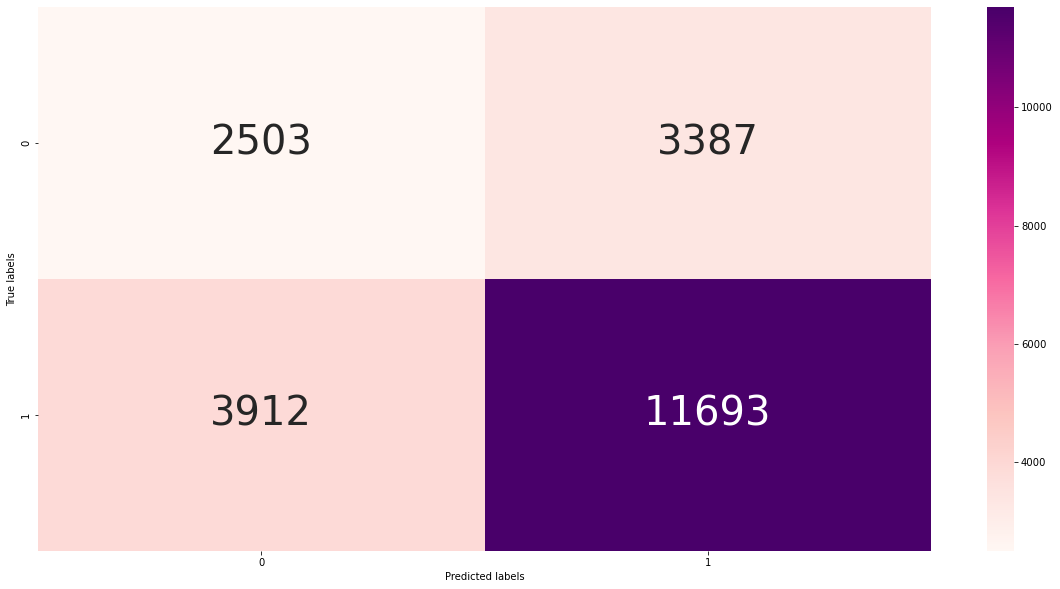

In [47]:
from sklearn.tree import DecisionTreeClassifier


tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

print_score(tree_clf, X_train, y_train, X_test, y_test, train=True)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=False)

In [48]:
test_score = accuracy_score(y_test, tree_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, tree_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["Decision Tree Classifier", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Logistic Regression,73.163583,73.626425
1,K-nearest neighbors,79.849258,71.509653
2,Decision Tree Classifier,94.608390,66.043266


## Random forest

Train Result:
Accuracy Score: 94.61%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.934834      0.950026  0.946084      0.942430      0.945779
recall         0.867627      0.976530  0.946084      0.922078      0.946084
f1-score       0.899978      0.963095  0.946084      0.931537      0.945450
support    14021.000000  36131.000000  0.946084  50152.000000  50152.000000
_______________________________________________
Confusion Matrix: 
 [[12165  1856]
 [  848 35283]]

Test Result:
Accuracy Score: 70.38%
_______________________________________________
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision     0.450084      0.776170  0.703838      0.613127      0.686817
recall        0.364346      0.831977  0.703838      0.598162      0.703838
f1-score      0.402702      0.803105  0.703838      0.602904      0.693388
suppo

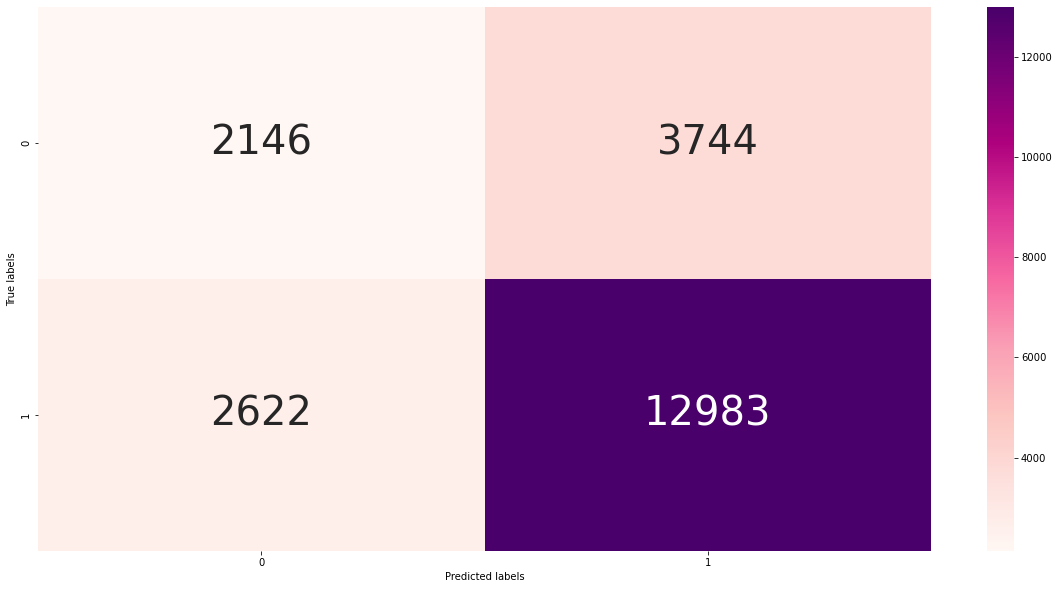

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf_clf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf_clf.fit(X_train, y_train)

print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)

In [50]:
test_score = accuracy_score(y_test, rf_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, rf_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["Random Forest Classifier", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Logistic Regression,73.163583,73.626425
1,K-nearest neighbors,79.849258,71.509653
2,Decision Tree Classifier,94.608390,66.043266
3,Random Forest Classifier,94.608390,70.383810


## XG Boost

C:\Users\Flo\anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Train Result:
Accuracy Score: 77.78%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.686641      0.794378  0.777815      0.740509      0.764258
recall         0.377576      0.933132  0.777815      0.655354      0.777815
f1-score       0.487230      0.858183  0.777815      0.672707      0.754476
support    14021.000000  36131.000000  0.777815  50152.000000  50152.000000
_______________________________________________
Confusion Matrix: 
 [[ 5294  8727]
 [ 2416 33715]]

Test Result:
Accuracy Score: 74.94%
_______________________________________________
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision     0.577600      0.779884  0.749384      0.678742      0.724454
recall        0.317827      0.912272  0.749384      0.615049      0.749384
f1-score      0.410032      0.840899  0.749384      0.625465      0.722834
suppo

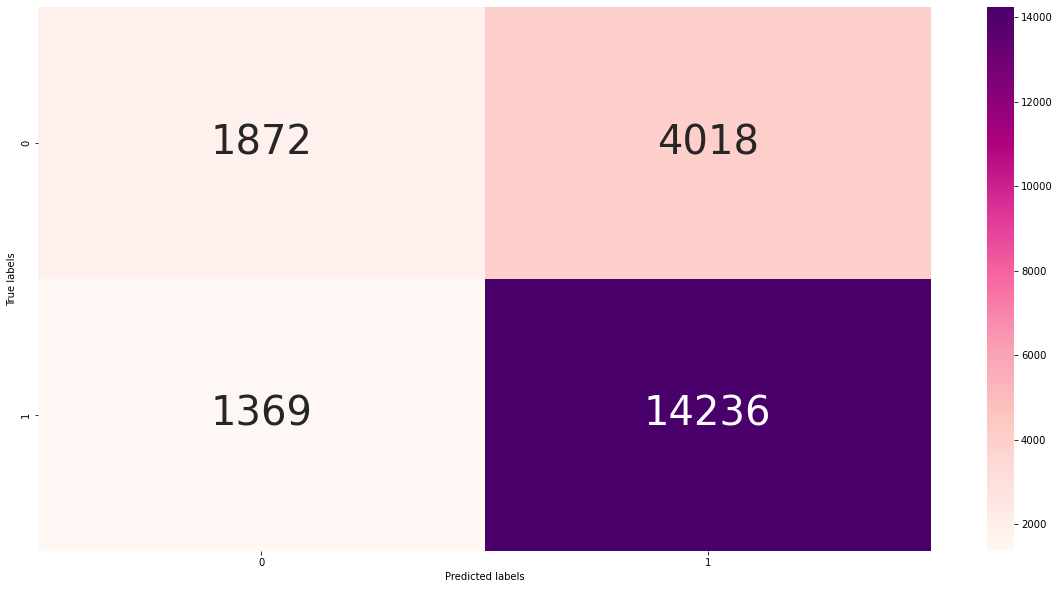

In [51]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(use_label_encoder=False)
xgb_clf.fit(X_train, y_train)

print_score(xgb_clf, X_train, y_train, X_test, y_test, train=True)
print_score(xgb_clf, X_train, y_train, X_test, y_test, train=False)

In [52]:
test_score = accuracy_score(y_test, xgb_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, xgb_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["XGBoost Classifier", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Logistic Regression,73.163583,73.626425
1,K-nearest neighbors,79.849258,71.509653
2,Decision Tree Classifier,94.608390,66.043266
3,Random Forest Classifier,94.608390,70.383810
4,XGBoost Classifier,77.781544,74.938358


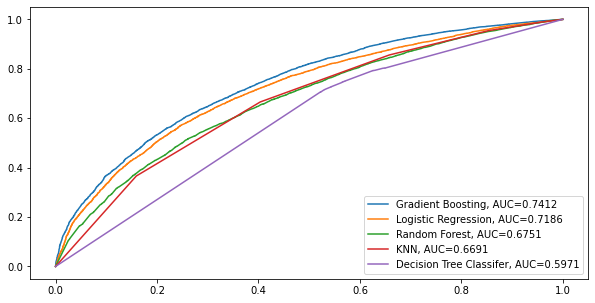

In [53]:
from sklearn import metrics
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
 
fig.set_figheight(5)
fig.set_figwidth(10)
#fit logistic regression model and plot ROC curve

#fit gradient boosted model and plot ROC curve


model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Gradient Boosting, AUC="+str(auc))

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
fpr, tpr,_  = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))


model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))


model = KNeighborsClassifier()
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="KNN, AUC="+str(auc))



model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Decision Tree Classifer, AUC="+str(auc))


#add legend
plt.legend()

XGB is our best model

C:\Users\Flo\anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Flo\anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Flo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=50. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\Flo\anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best paramters: {'nthread': 2, 'booster': 'gbtree'}
Train Result:
Accuracy Score: 77.78%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.686641      0.794378  0.777815      0.740509      0.764258
recall         0.377576      0.933132  0.777815      0.655354      0.777815
f1-score       0.487230      0.858183  0.777815      0.672707      0.754476
support    14021.000000  36131.000000  0.777815  50152.000000  50152.000000
_______________________________________________
Confusion Matrix: 
 [[ 5294  8727]
 [ 2416 33715]]

Test Result:
Accuracy Score: 74.94%
_______________________________________________
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision     0.577600      0.779884  0.749384      0.678742      0.724454
recall        0.317827      0.912272  0.749

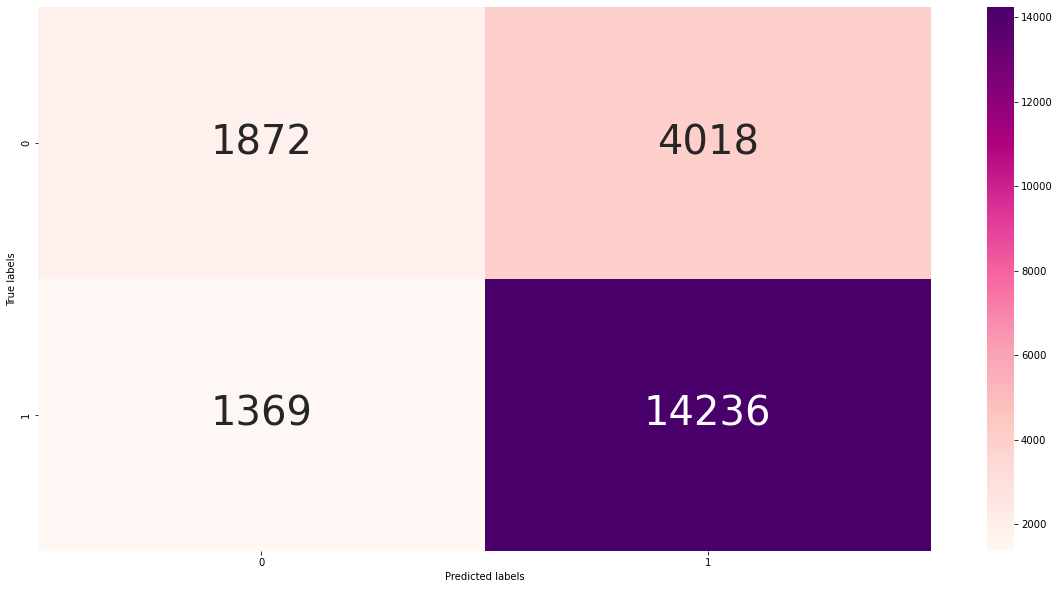

In [54]:
dict_parms={"booster":["gbtree", "gblinear"],"nthread":[2,3,4,5]}

xgb_clf = XGBClassifier(use_label_encoder=False)
xgb_cv = RandomizedSearchCV(
    xgb_clf, dict_parms, cv=3, n_iter=50, 
    scoring='accuracy', n_jobs=-1, verbose=1
)
xgb_cv.fit(X_train, y_train)
best_params = xgb_cv.best_params_
print(f"Best paramters: {best_params}")

xgb_clf = XGBClassifier(**best_params)
xgb_clf.fit(X_train, y_train)

print_score(xgb_clf, X_train, y_train, X_test, y_test, train=True)
print_score(xgb_clf, X_train, y_train, X_test, y_test, train=False)

We hypertuned our model

<AxesSubplot:>

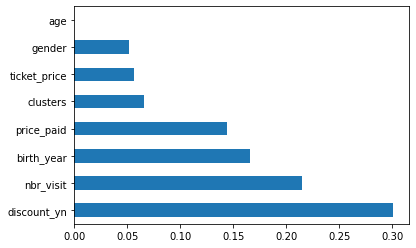

In [55]:
feat_importances = pd.Series(xgb_clf.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

Most important variable for the xgboost model are : the discount, the number of visit

# Question 7
Consider a marketing campaign addressing directly single customers. We know that each
contact costs 1 euro. We can also compute the consumer value for each single customer. We
can reasonably assume that a churner, contacted for the campaign has a probability of 10%
of not churning. Non-churners contacted are simply a cost of 1 euro. With this additional
information, draw a profit curve of each prediction model. Discuss your results.
(HINT: take the test set, consider the profit generated by the campaign for non-churners and
the expected profit for the churners, order them according to their predicted probability of
churn and plot the cumulative profit) (MAX 20 points).

In [56]:
# creation d'une variable nbr de visite à turin. Si visite à turin alors la ville donne 0.2€ à l'association

# Creer une colonne pour stocker le nombre de visites
#df['nb_visites_Turin'] = 0
df_Turin = df[df['museum_province'] == 'TO']
df2=df.groupby('consumer_ID') # on réduit les id (plus de repetitions)
df2 =df2.mean()
df2 = df2[df2['ticket_price'].notna()] 
# Filtrer les visites en Turin
df_Turin = df[df['museum_province'] == 'TO']

# compter le nombre de visites par client
nb_visites_par_client = df_Turin.groupby("consumer_ID").size().reset_index(name='nb_visites_Turin')

# Associer les valeurs de visites aux clients 
df = df.merge(nb_visites_par_client, on='consumer_ID', how='left')

# remplir les valeurs manquantes
df["nb_visites_Turin"].fillna(0, inplace=True)
df2=df.groupby('consumer_ID') # on réduit les id (plus de repetitions)
df2 =df2.mean()
df2 = df2[df2['ticket_price'].notna()] 



In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculer la valeur du consommateur pour chaque client
df2['consumer_value'] = 0.20 * df2['nb_visites_Turin']

# Ajouter une colonne pour le profit
df2['profit'] = 0

In [58]:
# Assigner des profits pour les clients qui quittent (churners) en utilisant la probabilité de ne pas quitter
df2['profit'] = np.where(df2['churn'] == 0, -1, df2['consumer_value'] * 0.1)

In [59]:
# Assigner des profits pour les clients qui ne quittent pas (non-churners)
df2.loc[df2['churn'] == 1, 'profit'] = df2['consumer_value'] - 1

In [60]:
df2 = df2.sort_values(by='profit', ascending=False)
df2['cumulative_profit'] = df2['profit'].cumsum()

In [61]:
df2.sort_values(by='cumulative_profit', ascending=False)
# max du cumulatif c'est 32860.8
# consumer_id 211631

,churn,price_paid,gender,birth_year,ticket_price,nbr_visit,discount_yn,age,nb_visites_Turin,consumer_value,profit,cumulative_profit
consumer_ID,,,,,,,,,,,,
203411,1.0,28.0,1.0,1945.0,5.100000,5.0,1.0,69.0,5.0,1.0,0.0,9498.6
229625,1.0,28.0,0.0,1992.0,3.700000,5.0,0.0,22.0,5.0,1.0,0.0,9498.6
240814,1.0,28.0,0.0,1943.0,4.600000,5.0,1.0,71.0,5.0,1.0,0.0,9498.6
201092,1.0,44.0,0.0,1960.0,4.800000,5.0,1.0,54.0,5.0,1.0,0.0,9498.6
18171,1.0,49.0,0.0,1951.0,3.194444,9.0,0.0,63.0,5.0,1.0,0.0,9498.6
...,...,...,...,...,...,...,...,...,...,...,...,...
93367,0.0,10.0,1.0,1993.0,4.166667,3.0,1.0,21.0,3.0,0.6,-1.0,-5037.4
202529,0.0,28.0,0.0,1987.0,4.800000,5.0,0.0,27.0,5.0,1.0,-1.0,-5038.4
202531,0.0,28.0,1.0,1985.0,4.800000,5.0,0.0,29.0,5.0,1.0,-1.0,-5039.4


No handles with labels found to put in legend.


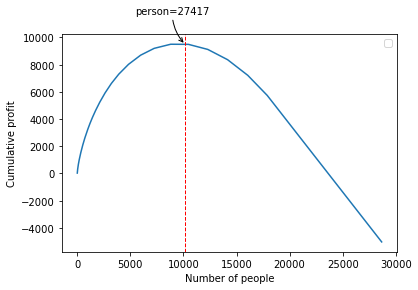

In [62]:
opo= range(len(df2))
# Tracer la courbe de profit
plt.plot(opo ,df2['cumulative_profit'])
label='Cumulative profit'
plt.ylabel('Cumulative profit')
plt.xlabel('Number of people')
idx_person = df2.index.get_loc(211631)
#position de la personne "211631"
plt.axvline(x=idx_person, color='red', linewidth=1, linestyle='--')

plt.annotate(f"person=27417", (idx_person, df2["cumulative_profit"].max()), xytext=(-50, 30), textcoords='offset points',
             arrowprops=dict(arrowstyle="->",
                             connectionstyle="arc3,rad=.2"))

plt.legend()
plt.show()


after 27417 contacted people, it's not worth enough to contact more people